# Modeling EuroBERT Notebook (Boizard et al. 2025)

**Based on the developed pipeline in `template_logreg_tfidf.ipynb`**

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import torch.nn as nn

from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
)

root_path = Path.cwd().parents[1]  #go to root
sys.path.append(str(root_path))
from src.evaluation_visualization import (
    plot_learning_curves,
    plot_confusion_matrix,
    plot_roc_and_pr_curves,
    plot_threshold_curves,
    extended_classification_report,
    get_metrics_dict,
    quick_f2_score_default_threshold,
    plot_skorch_history
)
from joblib import dump
from src.eurobert_skorch import make_eurobert_skorch #eurobert end-to-end from boizard et al 2025
from src.preprocessing import process_file
from src.optimize_threshold import (
    optimize_threshold_with_cv,
    get_threshold_evaluation_data,
    get_threshold_evaluation_data_cv
)
from src.optuna_optimizer import (
    optimize_with_optuna_tpe,
    sample_class_weight_value,
    grid_search_with_optuna
)
from src.optuna_visualizations import (
    plot_optuna_study_analysis,
    quick_optuna_analysis
)

from src.phrase_transformer import PhraseDetector

c:\Users\tdoro\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- Repro Setup --- we try to make everything reproducible
import os, random, numpy as np, torch
SEED = 42  #global seed

random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

torch.use_deterministic_algorithms(True)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False
torch.set_float32_matmul_precision('high')

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
torch.set_num_threads(1)


In [3]:
import torch #we want to use the gpu

print("Torch-Version:", torch.__version__)
print("CUDA-Toolchain in Torch:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU-Name:", torch.cuda.get_device_name(0))

#test
x = torch.randn(5000, 5000, device="cuda")
y = torch.matmul(x, x)
print("Device:", y.device)


Torch-Version: 2.5.1
CUDA-Toolchain in Torch: 12.4
CUDA available: True
GPU-Name: NVIDIA GeForce RTX 4050 Laptop GPU
Device: cuda:0


In [4]:
#debug
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1" 

**a) EuroBERT Classifier with basic preprocessed data**

In [5]:
# Load and preprocess data (basic mode)
df_basiccleaned = process_file(
    filepath=f'{root_path}/05modeling_pipelines/1klabeled_segments.csv',
    file_format='csv',
    text_key='SegmentText', 
    mode='basic'  # basic cleaning mode
)

# Map labels to binary values
df_basiccleaned['Label'] = df_basiccleaned['Label'].map({"['relevant']": 1, "['irrelevant']": 0})

EuroBERT TPE basic

c:\Users\tdoro\Documents\GitHub\clean-repo\src\eurobert_skorch.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self._scaler = GradScaler() if self.use_amp else None
c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\tdoro\Documents\GitHub\clean-repo\src\eurobert_skorch.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self._scaler = GradScaler() if self.use_amp else None


Starting Optuna hyperparameter optimization ...


`torch_dtype` is deprecated! Use `dtype` instead!
Some weights of EuroBertForSequenceClassification were not initialized from the model checkpoint at EuroBERT/EuroBERT-210m and are newly initialized: ['classifier.bias', 'classifier.weight', 'dense.bias', 'dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\tdoro\Documents\GitHub\clean-repo\src\eurobert_skorch.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
c:\Users\tdoro\Documents\GitHub\clean-repo\src\eurobert_skorch.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
c:\Users\tdoro\Documents\GitHub\clean-repo\src\eurobert_skorch.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
 

Best parameters found by Optuna TPE: {'clf__lr': 1.0954637695539153e-05, 'clf__batch_size': 8, 'clf__max_epochs': 5, 'clf__optimizer__weight_decay': 0.04195759783602837, 'bert_pos_weight': 45.55032537269855}
Best F2 score during optimization: 0.798

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


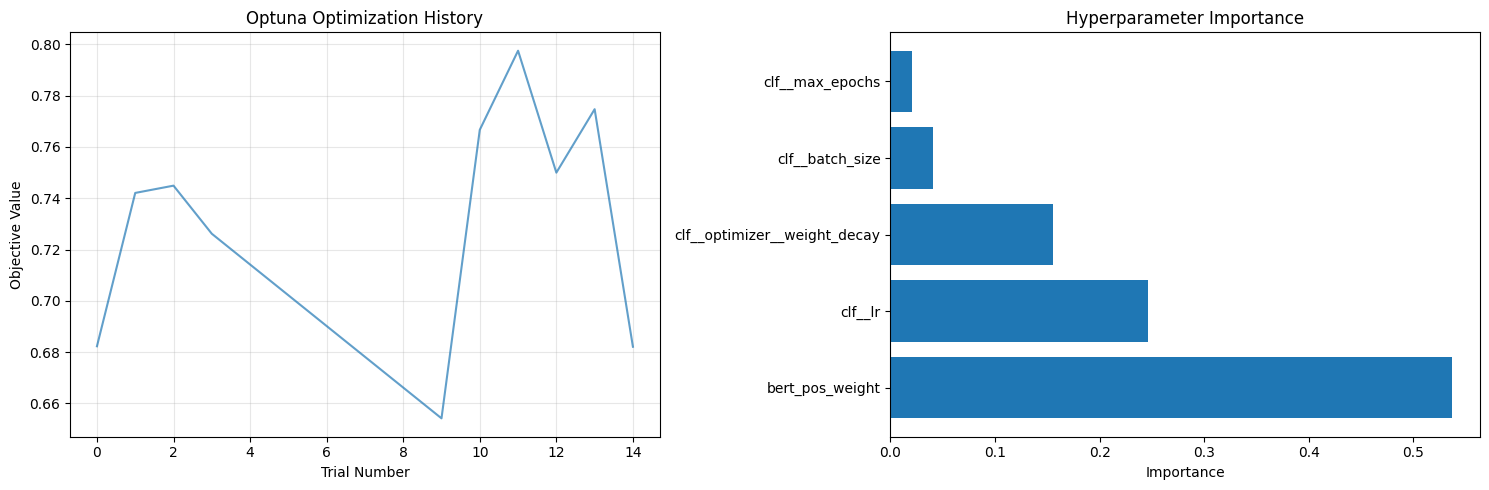


2. Parameter Value Distributions:


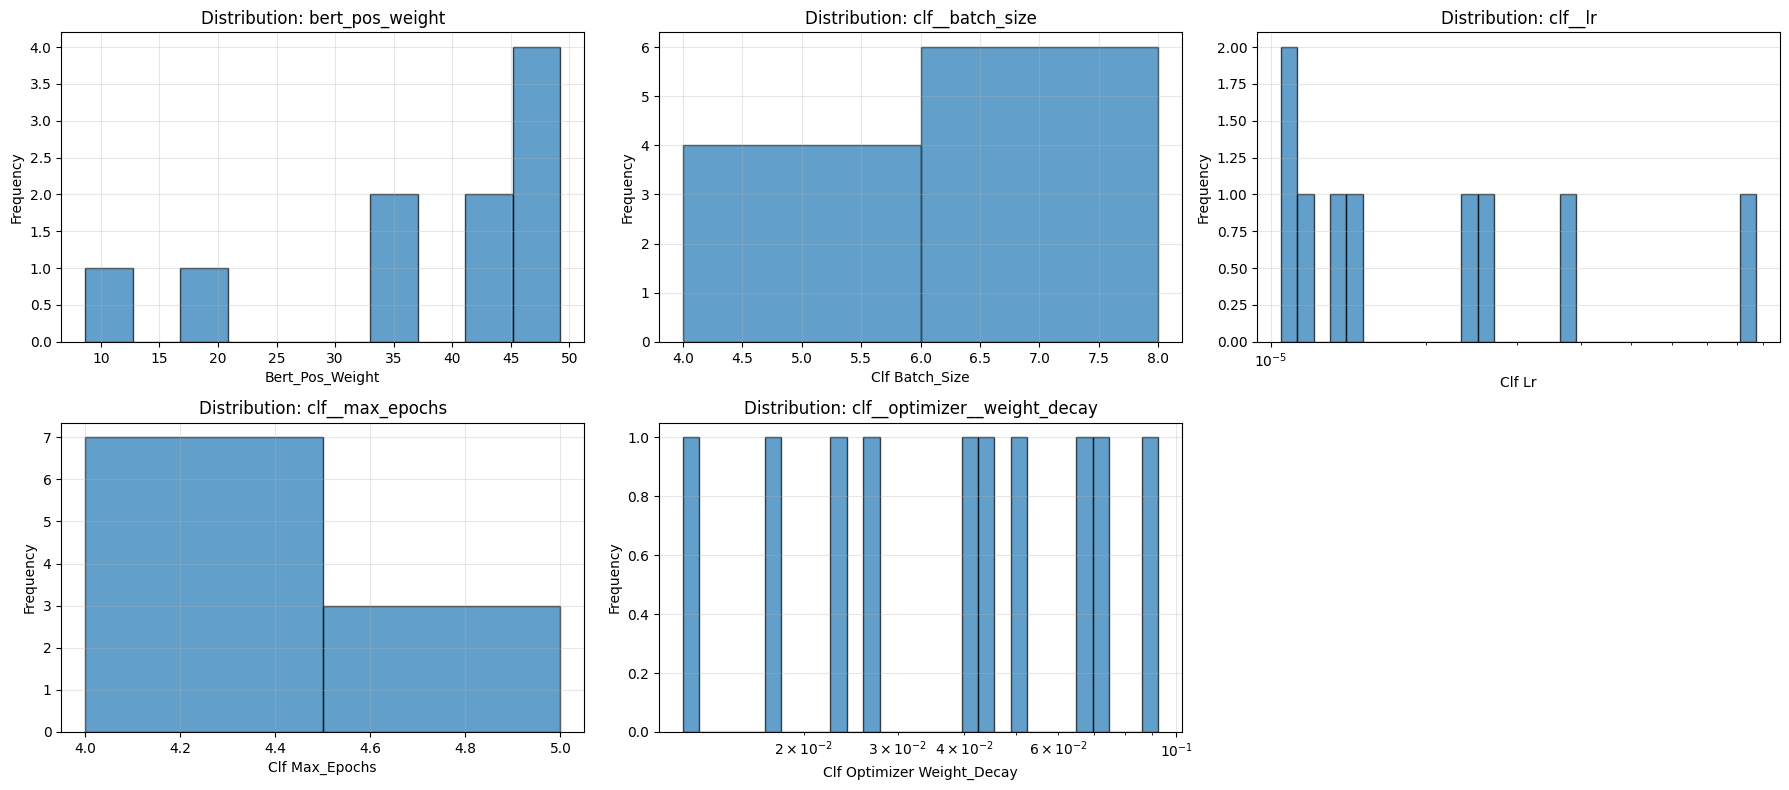


3. Performance vs Individual Parameters:


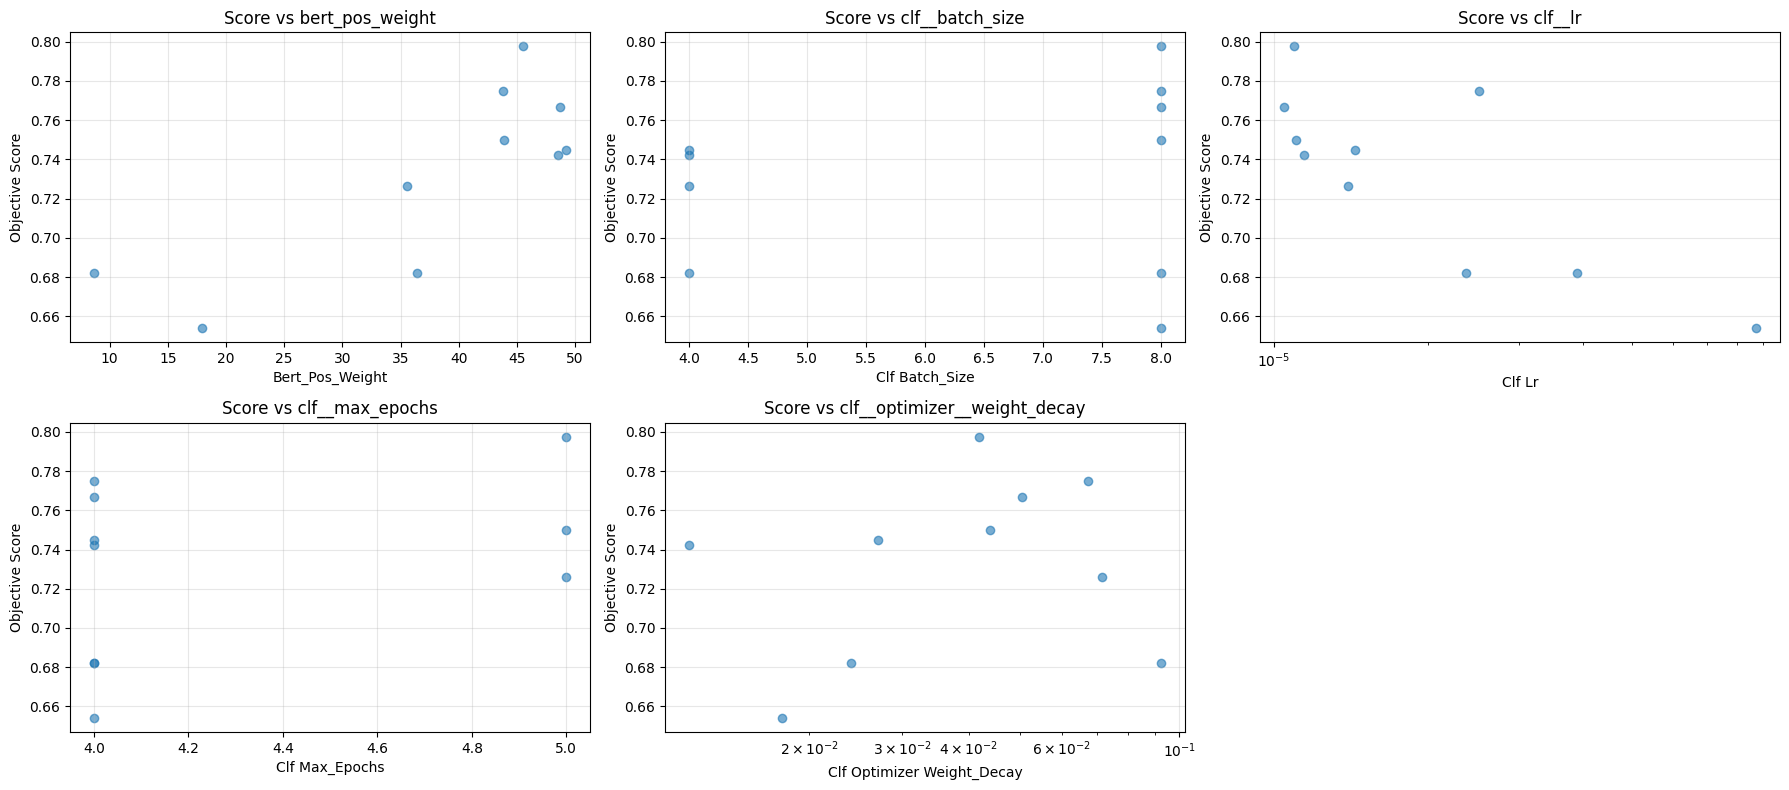


4. Convergence Analysis:


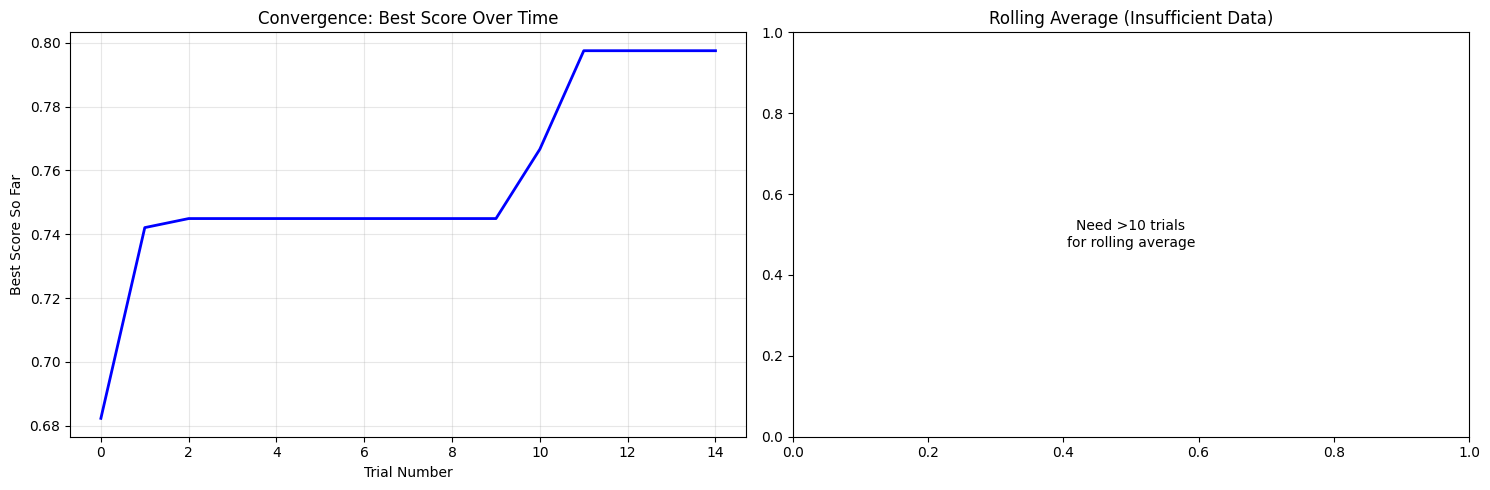


5. Trial Status Overview:


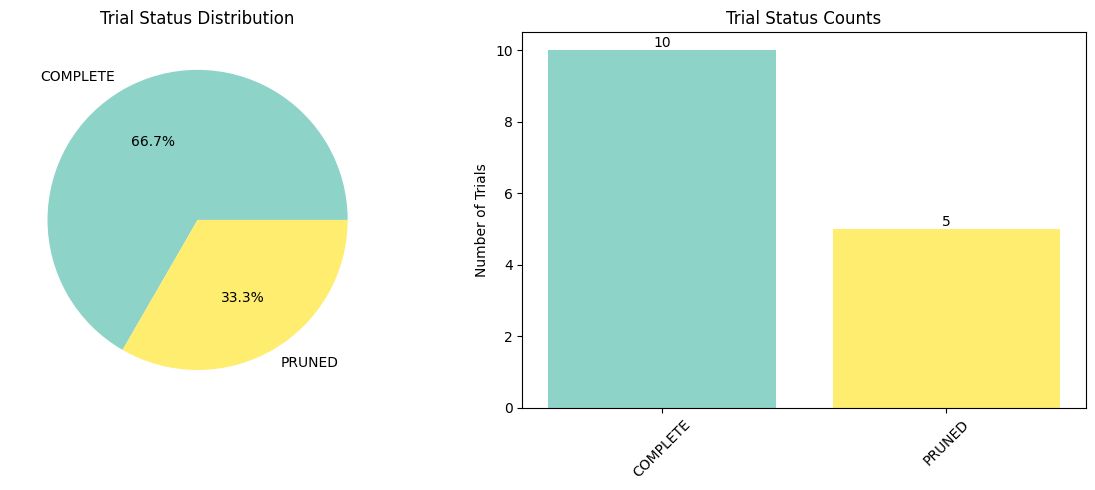


6. Top 10 Best Trials:
Rank Trial#  Score      bert_pos_weight batch_size   lr           max_epochs   weight_decay
-------------------------------------------------------------------------------------------
1    11      0.7976     45.5503      8            0.0000       5            0.0420      
2    13      0.7747     43.7923      8            0.0000       4            0.0672      
3    10      0.7667     48.6714      8            0.0000       4            0.0504      
4    12      0.7500     43.8990      8            0.0000       5            0.0438      
5    2       0.7449     49.2466      4            0.0000       4            0.0270      
6    1       0.7421     48.5256      4            0.0000       4            0.0119      
7    3       0.7262     35.5842      4            0.0000       5            0.0716      
8    0       0.6823     8.6437       4            0.0000       4            0.0240      
9    14      0.6821     36.4273      8            0.0000       4            0.09

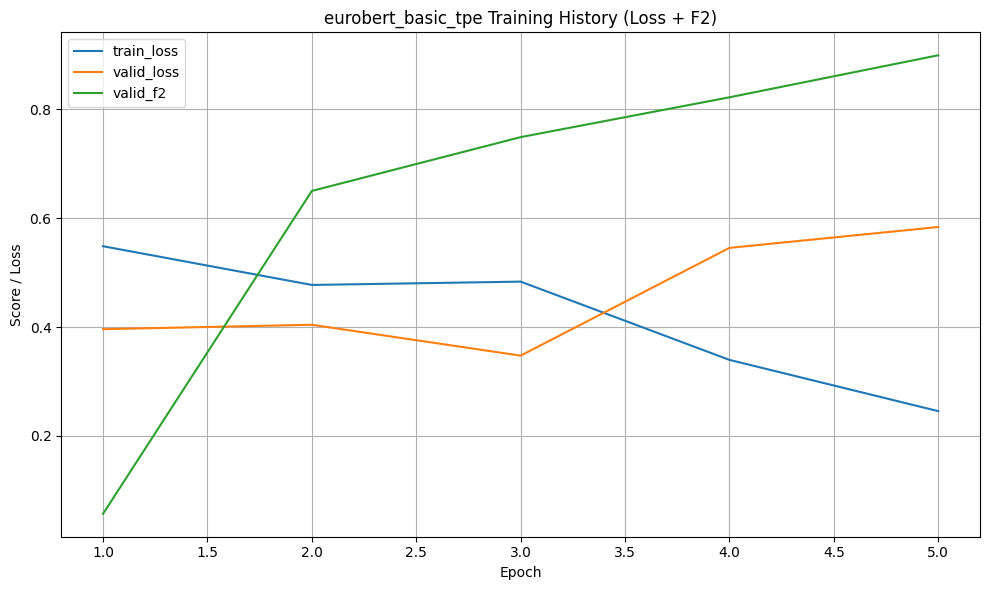


Optimizing threshold with nested cross-validation (coarse-to-fine)...


c:\Users\tdoro\Documents\GitHub\clean-repo\src\eurobert_skorch.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
c:\Users\tdoro\Documents\GitHub\clean-repo\src\eurobert_skorch.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Optimized threshold: 0.775
CV F2-score with optimized threshold: 0.933

Generating unbiased threshold visualization...


c:\Users\tdoro\Documents\GitHub\clean-repo\src\eurobert_skorch.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Final Threshold: 0.78
F2-score with default threshold (0.5): 0.735

Test Set Performance:
              precision    recall  f1-score   support

           0       0.91      0.86      0.88       146
           1       0.66      0.76      0.71        54

    accuracy                           0.83       200
   macro avg       0.78      0.81      0.79       200
weighted avg       0.84      0.83      0.83       200

Additional Metrics:
Accuracy   0.830
F2-score   0.737
AUC-ROC    0.903
AUC-PR     0.823



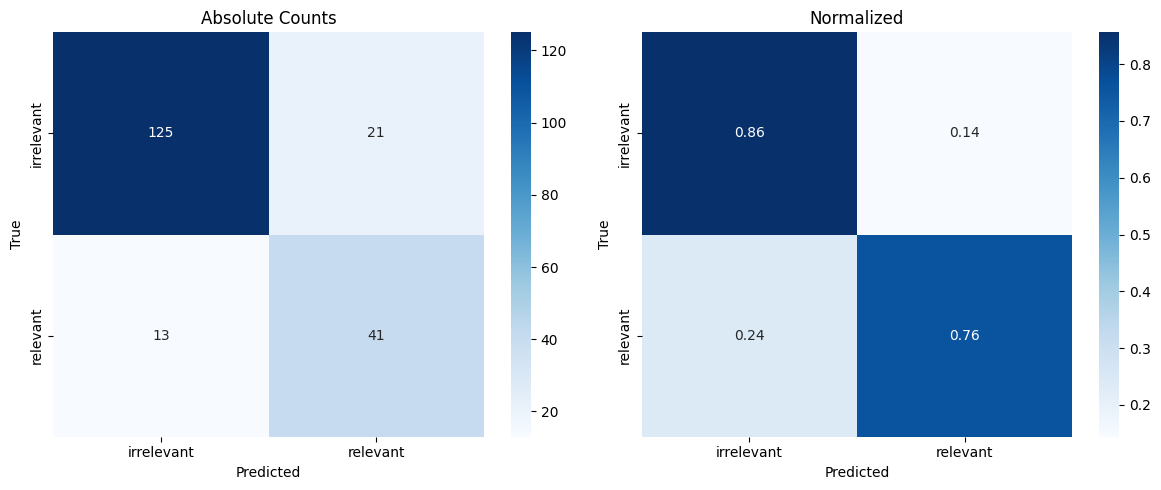

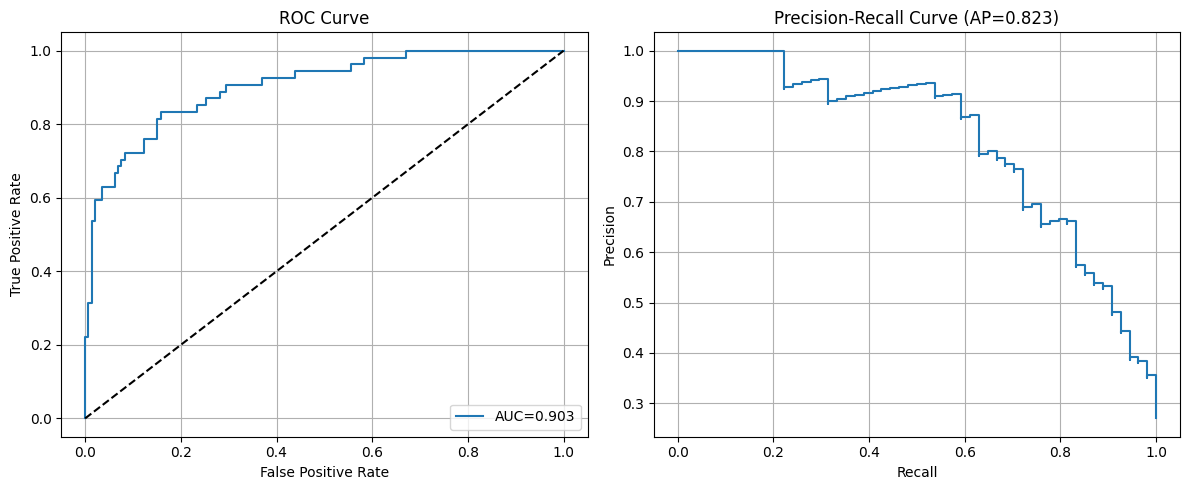

c:\Users\tdoro\Documents\GitHub\clean-repo\src\eurobert_skorch.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Model saved as model_eurobert_basic_tpe.joblib


In [6]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_basiccleaned["SegmentText"], df_basiccleaned["Label"],
    test_size=0.2,
    stratify=df_basiccleaned["Label"],
    random_state=42
)


pipeline_eurobert = Pipeline([
    ("clf", make_eurobert_skorch(
        model_name="EuroBERT/EuroBERT-210m",
        max_length=1000,
        max_epochs=5,
        lr=2e-5,
        batch_size=16,
        force_cuda=True
    ))
])

# CV Strategy (consistent across all sections)
# test with 3 to run faster 
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

# Optuna Parameter Space 
print("Starting Optuna hyperparameter optimization ...")

# Define parameter space for Optuna optimization
param_space = {
    "clf__lr": lambda t: t.suggest_float("clf__lr", 1e-5, 1e-4, log=True),
    "clf__batch_size": lambda t: t.suggest_categorical("clf__batch_size", [4, 8]),
    "clf__max_epochs": lambda t: t.suggest_int("clf__max_epochs", 2, 5),
    "clf__optimizer__weight_decay": lambda t: t.suggest_float("clf__optimizer__weight_decay", 0.01, 0.1),
    "clf__criterion__weight": lambda t: torch.tensor([1.0, t.suggest_float("bert_pos_weight", 1.0, 50.0)], dtype=torch.float32),
}

model_name = "eurobert_basic_tpe"

# Execute Optuna optimization with TPE sampler
best_model, best_params, study = optimize_with_optuna_tpe(
    estimator=pipeline_eurobert,
    param_space=param_space,
    X=X_dev,
    y=y_dev,
    cv=cv,
    model_type="eurobert",
    n_trials=15,           
    n_startup_trials=2,
    n_warmup_steps=2,
    intervall_steps=1,
    direction="maximize",
    random_state=SEED,
    verbose=False,
    log_to_file=True,
    model_name=model_name
)
print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# plot loss curves
net = base_model.named_steps['clf']
plot_skorch_history(net=net, keys=['train_loss', 'valid_loss','valid_f2'])
plt.title(f'{model_name} Training History (Loss + F2)')
plt.show()


# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=15,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=1,
    random_state=SEED,
    retrain=False #eurobert big model
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")
'''
viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10),
    n_jobs=1  # Use single thread for learning curves to avoid overhead 
)
plt.suptitle(f'{model_name} with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()
'''
# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1]

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print(f"F2-score with default threshold (0.5): {quick_f2_score_default_threshold(y_test, y_test_proba):.3f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1]
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': model_name, 
    'preprocessing_type': 'basic',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")



EuroBERT basic GridSearch

c:\Users\tdoro\Documents\GitHub\clean-repo\src\eurobert_skorch.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self._scaler = GradScaler() if self.use_amp else None
c:\Users\tdoro\Documents\GitHub\clean-repo\src\eurobert_skorch.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self._scaler = GradScaler() if self.use_amp else None


Starting Optuna hyperparameter optimization ...


`torch_dtype` is deprecated! Use `dtype` instead!
Some weights of EuroBertForSequenceClassification were not initialized from the model checkpoint at EuroBERT/EuroBERT-210m and are newly initialized: ['classifier.bias', 'classifier.weight', 'dense.bias', 'dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\tdoro\Documents\GitHub\clean-repo\src\eurobert_skorch.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
c:\Users\tdoro\Documents\GitHub\clean-repo\src\eurobert_skorch.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
c:\Users\tdoro\Documents\GitHub\clean-repo\src\eurobert_skorch.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
 

Best parameters found by Optuna TPE: {'clf__lr': 1e-05, 'clf__optimizer__weight_decay': 0.05, 'mlp_pos_weight': 60.0, 'clf__batch_size': 8, 'clf__max_epochs': 5}
Best F2 score during optimization: 0.776

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


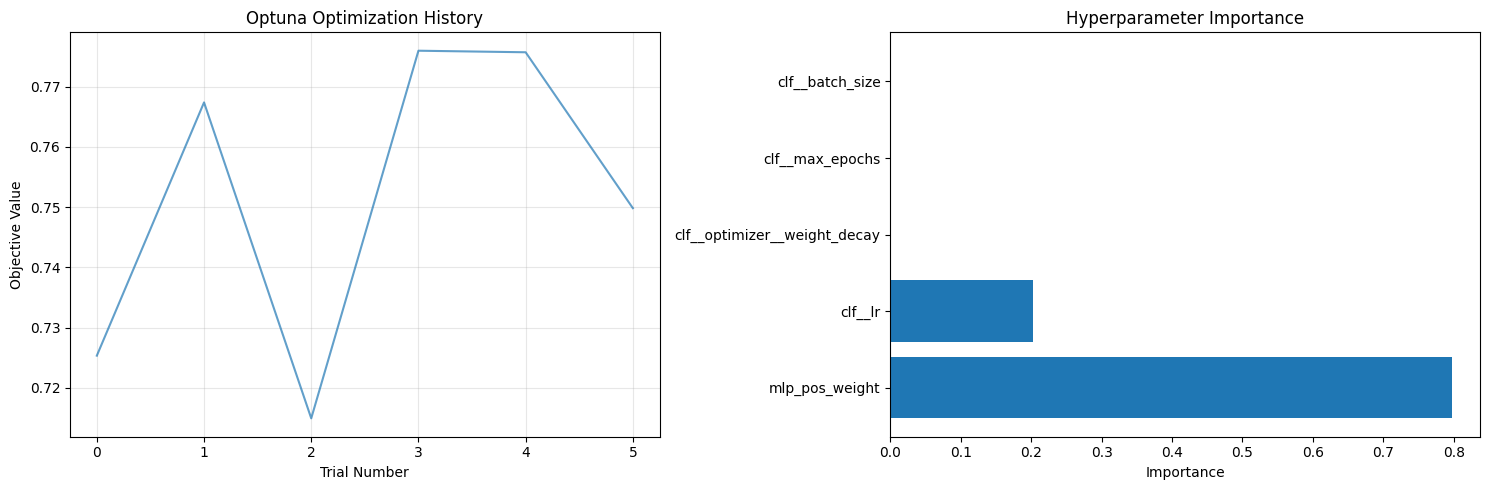


2. Parameter Value Distributions:


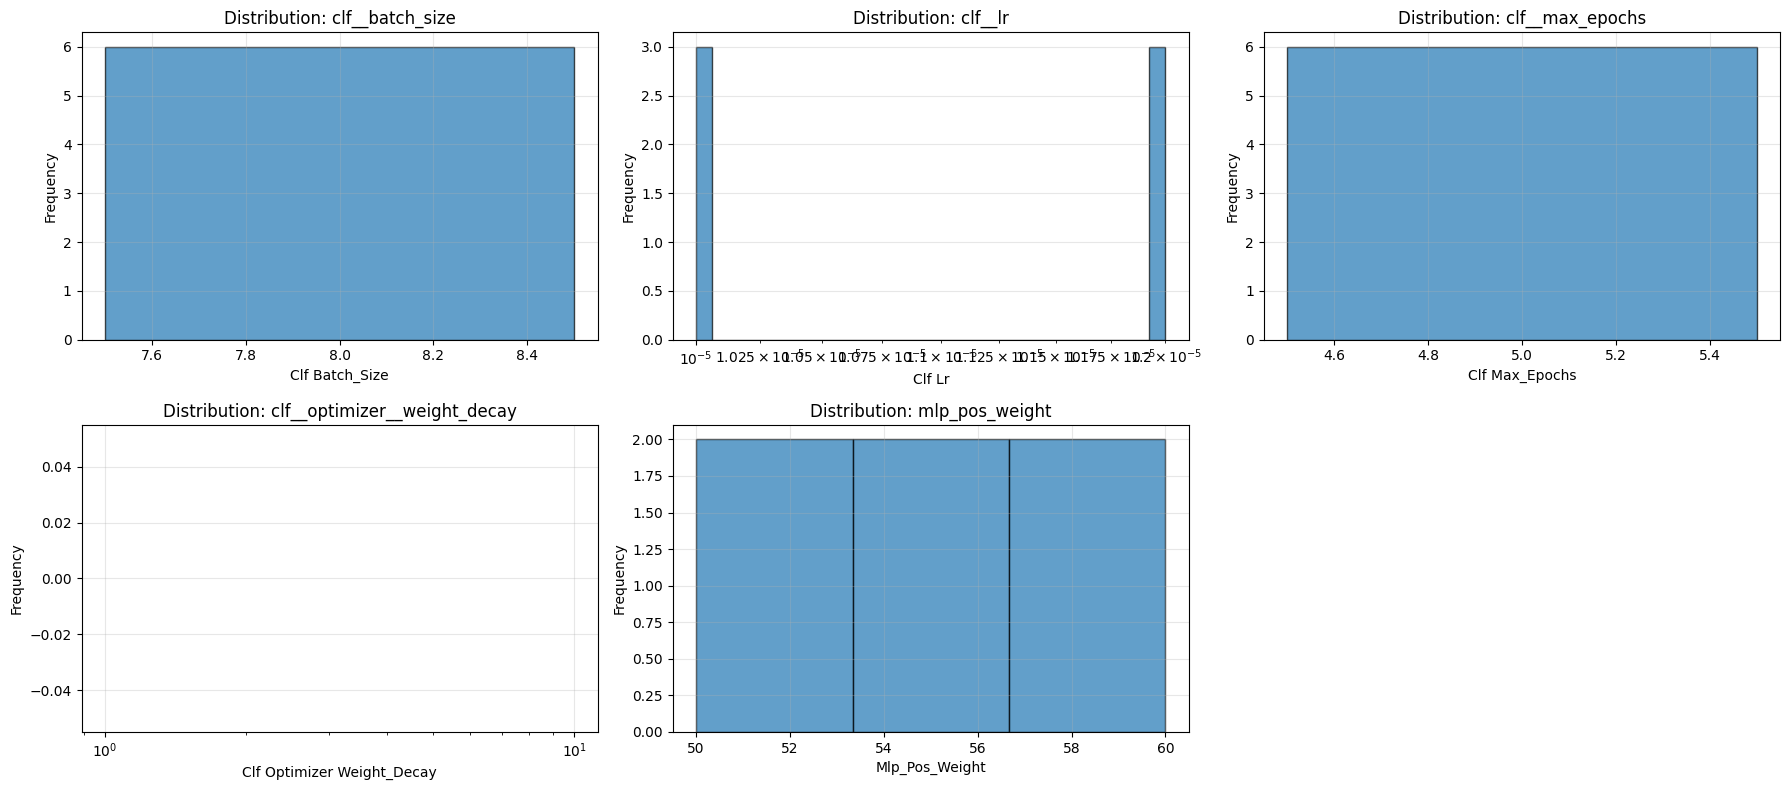


3. Performance vs Individual Parameters:


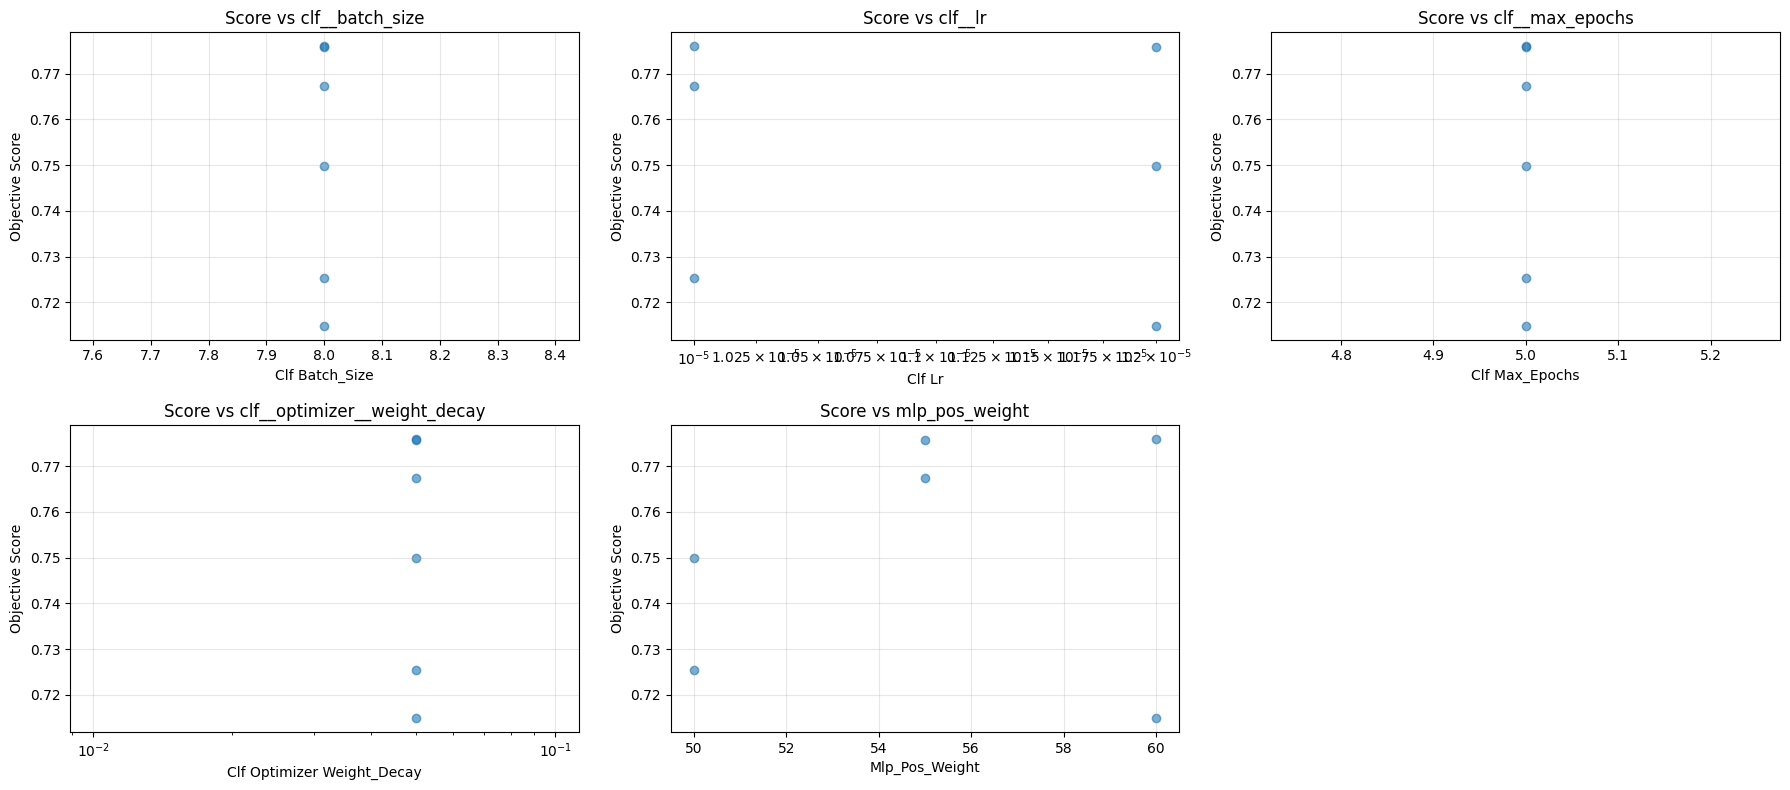


4. Convergence Analysis:


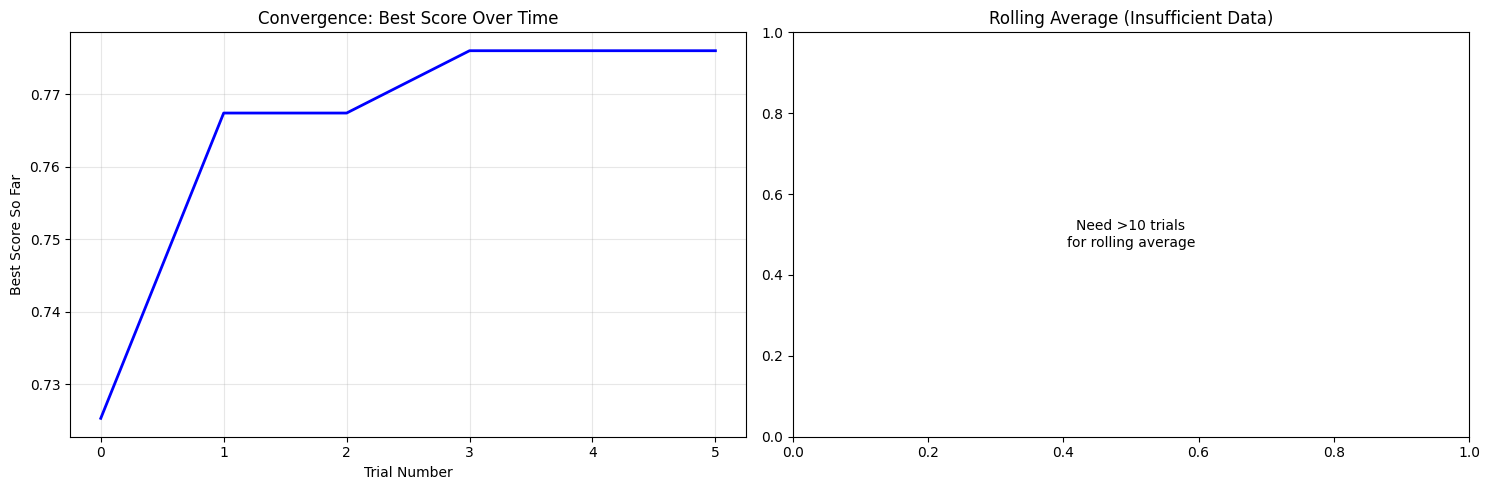


5. Trial Status Overview:


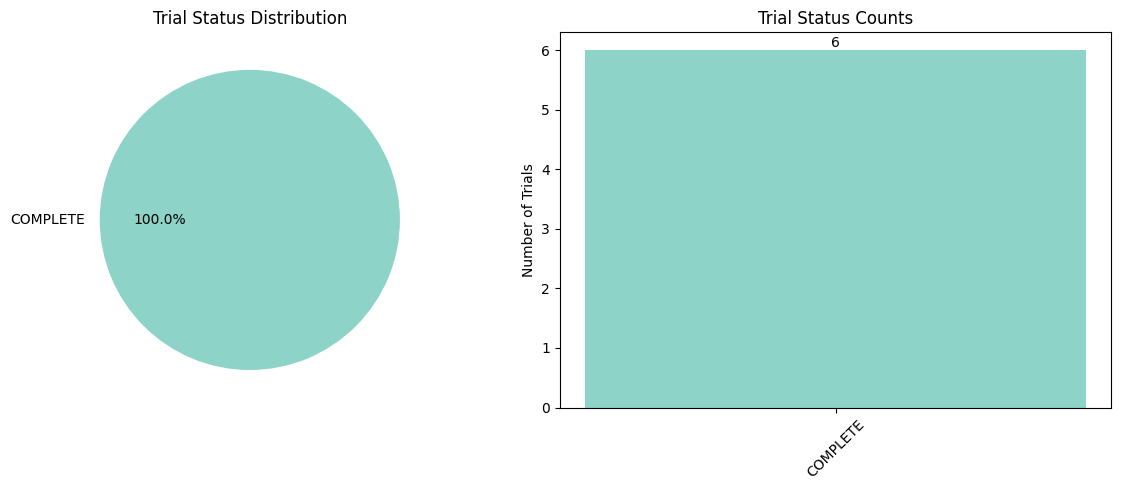


6. Top 10 Best Trials:
Rank Trial#  Score      batch_size   lr           max_epochs   weight_decay mlp_pos_weight
------------------------------------------------------------------------------------------
1    3       0.7760     8            0.0000       5            0.0500       60.0000     
2    4       0.7757     8            0.0000       5            0.0500       55.0000     
3    1       0.7674     8            0.0000       5            0.0500       55.0000     
4    5       0.7498     8            0.0000       5            0.0500       50.0000     
5    0       0.7253     8            0.0000       5            0.0500       50.0000     
6    2       0.7149     8            0.0000       5            0.0500       60.0000     

7. Study Statistics Summary:
• Total trials: 6
• Successful trials: 6
• Failed trials: 0
• Success rate: 100.0%
• Best trial: #3
• Best objective value: 0.7760
• Score statistics:
  - Mean: 0.7515
  - Std:  0.0240
  - Min:  0.7149
  - Max:  0.7760
• Study dir

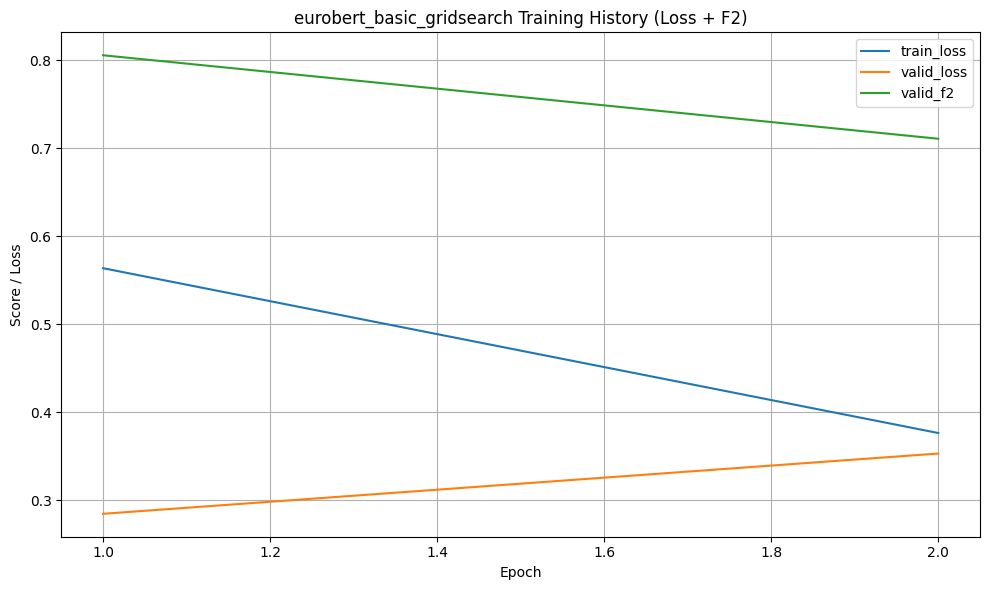


Optimizing threshold with nested cross-validation (coarse-to-fine)...


c:\Users\tdoro\Documents\GitHub\clean-repo\src\eurobert_skorch.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
c:\Users\tdoro\Documents\GitHub\clean-repo\src\eurobert_skorch.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Optimized threshold: 0.010
CV F2-score with optimized threshold: 0.883

Generating unbiased threshold visualization...


c:\Users\tdoro\Documents\GitHub\clean-repo\src\eurobert_skorch.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Final Threshold: 0.01
F2-score with default threshold (0.5): 0.494

Test Set Performance:
              precision    recall  f1-score   support

           0       0.93      0.88      0.90       146
           1       0.71      0.81      0.76        54

    accuracy                           0.86       200
   macro avg       0.82      0.85      0.83       200
weighted avg       0.87      0.86      0.86       200

Additional Metrics:
Accuracy   0.860
F2-score   0.791
AUC-ROC    0.904
AUC-PR     0.788



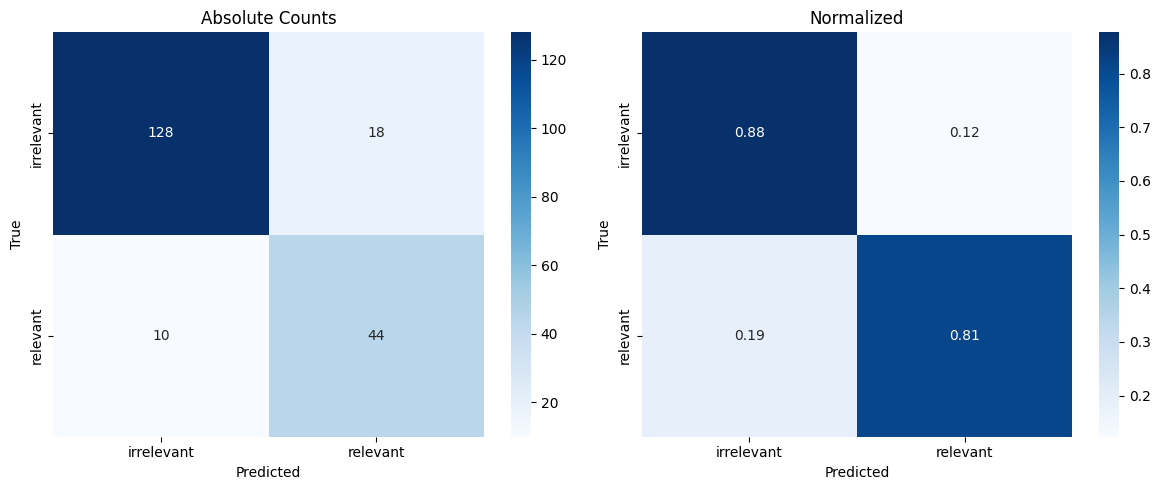

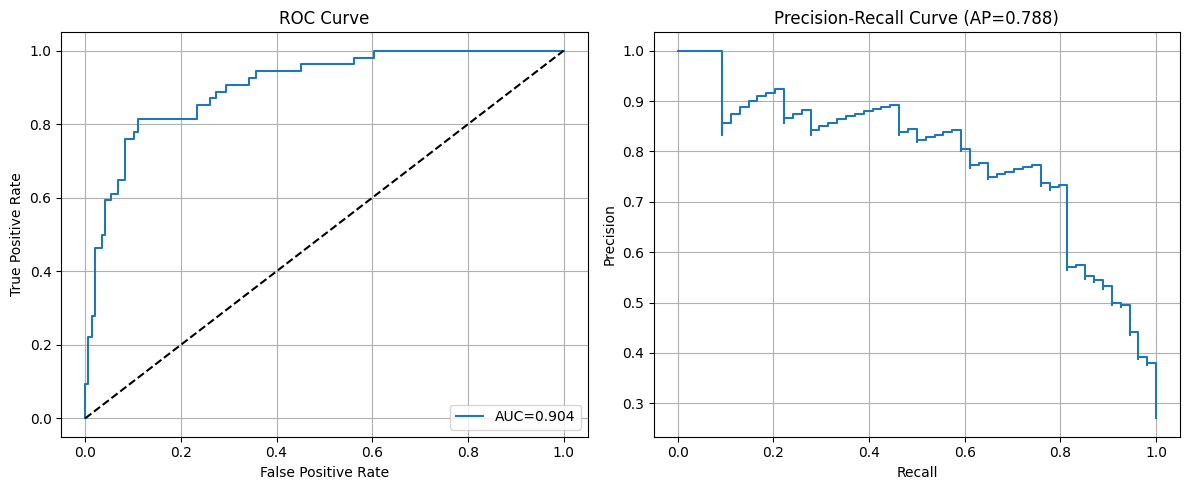

c:\Users\tdoro\Documents\GitHub\clean-repo\src\eurobert_skorch.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Model saved as model_eurobert_basic_gridsearch.joblib


In [6]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_basiccleaned["SegmentText"], df_basiccleaned["Label"],
    test_size=0.2,
    stratify=df_basiccleaned["Label"],
    random_state=42
)


pipeline_eurobert = Pipeline([
    ("clf", make_eurobert_skorch(
        model_name="EuroBERT/EuroBERT-210m",
        max_length=1000,
        max_epochs=5,
        lr=2e-5,
        batch_size=16,
        force_cuda=True
    ))
])

# CV Strategy (consistent across all sections)
# test with 3 to run faster 
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

# Optuna Parameter Space 
print("Starting Optuna hyperparameter optimization ...")

param_grid = {
    "clf__lr": [1e-5, 1.2e-5],
    "clf__optimizer__weight_decay": [0.05],
    "mlp_pos_weight": [50.0, 55.0, 60.0],
    "clf__batch_size": [8],
    "clf__max_epochs": [5],
}

model_name = "eurobert_basic_gridsearch"

#grid search
best_model, best_params, study = grid_search_with_optuna(
    estimator=pipeline_eurobert,
    param_grid=param_grid,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    random_state=42,
    model_name=model_name,
    n_jobs=1
)

print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# plot loss curves
net = base_model.named_steps['clf']
plot_skorch_history(net=net, keys=['train_loss', 'valid_loss','valid_f2'])
plt.title(f'{model_name} Training History (Loss + F2)')
plt.show()


# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=15,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=1,
    random_state=SEED,
    retrain=False #eurobert big model
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")
'''
viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10),
    n_jobs=1  # Use single thread for learning curves to avoid overhead 
)
plt.suptitle(f'{model_name} with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()
'''
# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1]

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print(f"F2-score with default threshold (0.5): {quick_f2_score_default_threshold(y_test, y_test_proba):.3f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1]
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': model_name, 
    'preprocessing_type': 'basic',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")



**b) EuroBERT Classifier with advanced preprocessed data**

In [5]:
# Load and preprocess data (advanced mode)
df_advancedcleaned = process_file(
    filepath=f'{root_path}/05modeling_pipelines/1klabeled_segments.csv',
    file_format='csv',
    text_key='SegmentText', 
    mode='advanced'  # basic cleaning mode
)

# Map labels to binary values
df_advancedcleaned['Label'] = df_advancedcleaned['Label'].map({"['relevant']": 1, "['irrelevant']": 0})

c:\Users\tdoro\Documents\GitHub\clean-repo\src\eurobert_skorch.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self._scaler = GradScaler() if self.use_amp else None
c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\tdoro\Documents\GitHub\clean-repo\src\eurobert_skorch.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self._scaler = GradScaler() if self.use_amp else None


Starting Optuna hyperparameter optimization ...


`torch_dtype` is deprecated! Use `dtype` instead!
Some weights of EuroBertForSequenceClassification were not initialized from the model checkpoint at EuroBERT/EuroBERT-210m and are newly initialized: ['classifier.bias', 'classifier.weight', 'dense.bias', 'dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\tdoro\Documents\GitHub\clean-repo\src\eurobert_skorch.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
c:\Users\tdoro\Documents\GitHub\clean-repo\src\eurobert_skorch.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
c:\Users\tdoro\Documents\GitHub\clean-repo\src\eurobert_skorch.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
 

Best parameters found by Optuna TPE: {'clf__lr': 2.368863950364079e-05, 'clf__batch_size': 4, 'clf__max_epochs': 4, 'clf__optimizer__weight_decay': 0.02404167763981929, 'bert_pos_weight': 29.673468256946737}
Best F2 score during optimization: 0.840

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


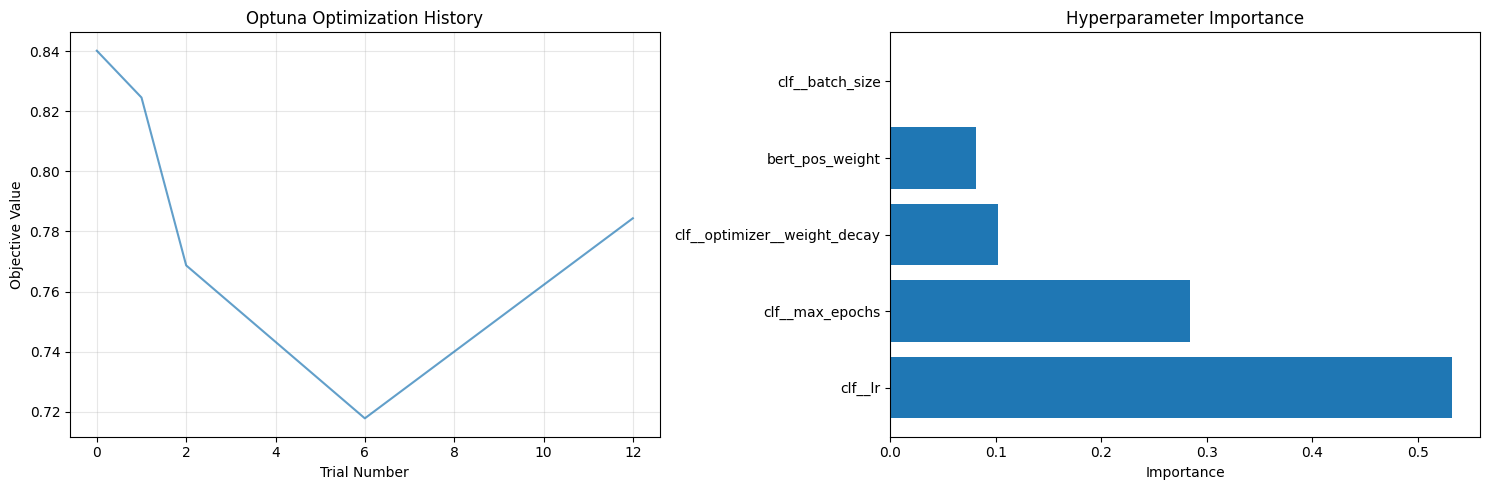


2. Parameter Value Distributions:


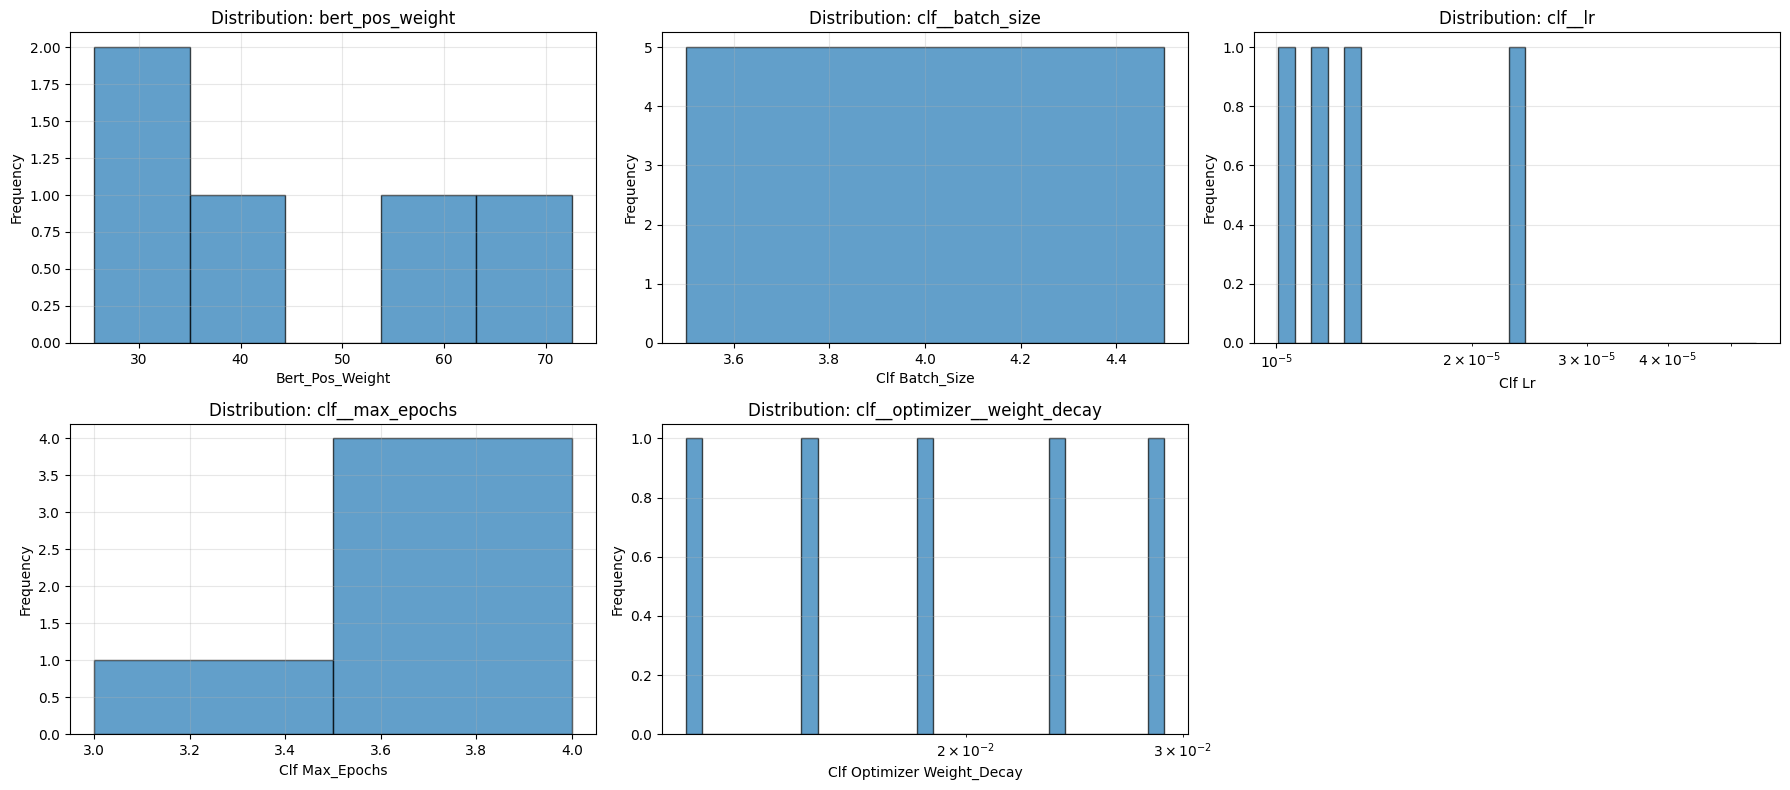


3. Performance vs Individual Parameters:


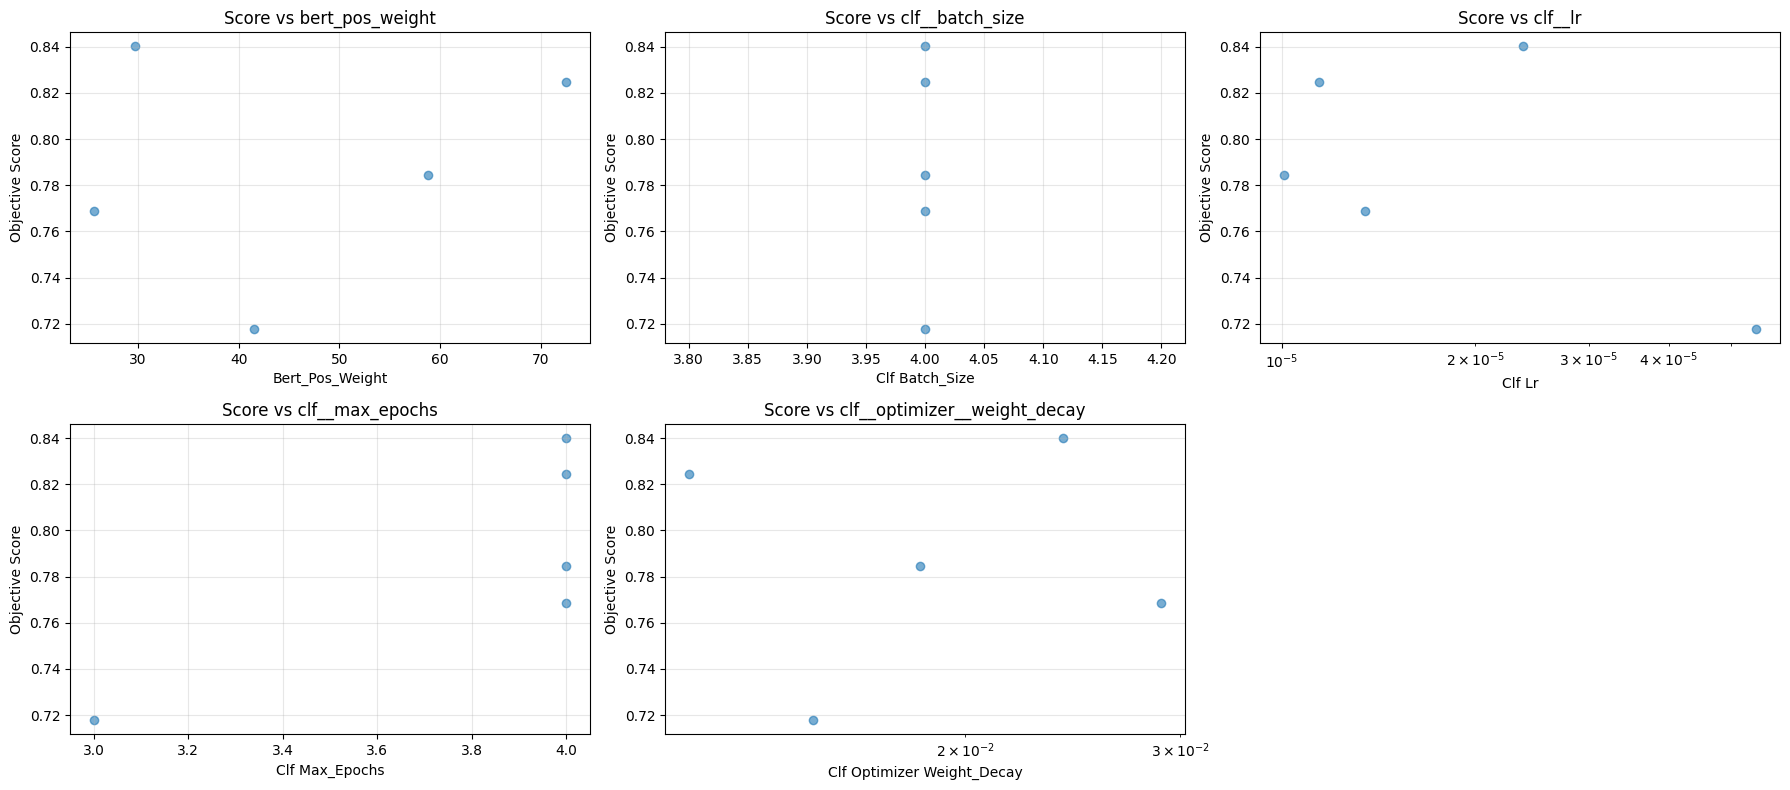


4. Convergence Analysis:


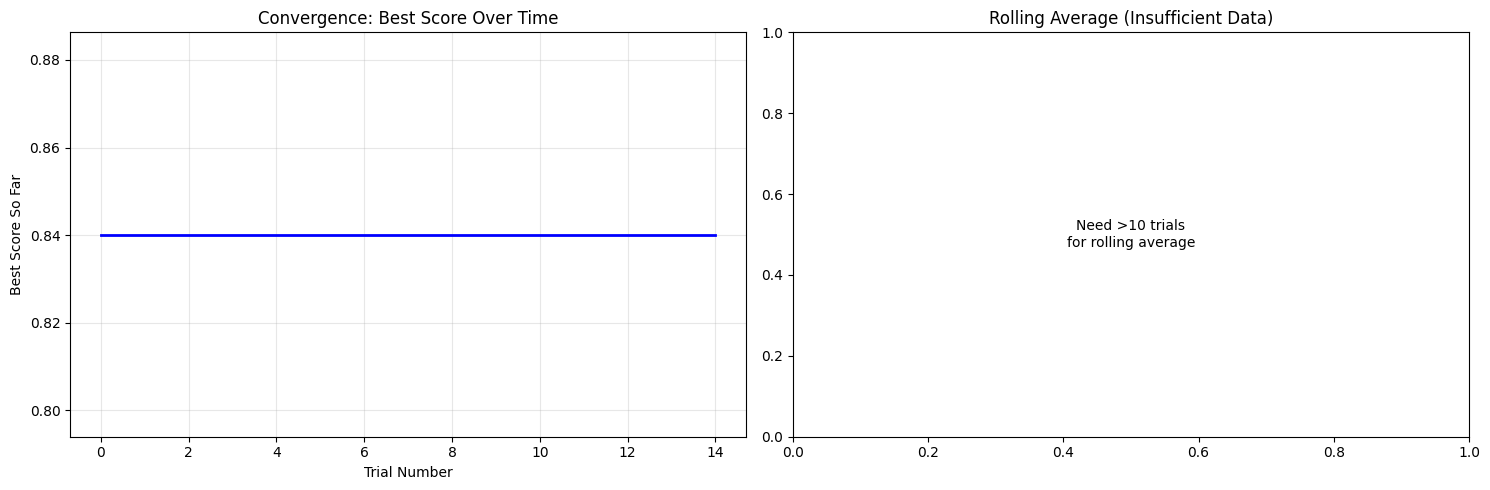


5. Trial Status Overview:


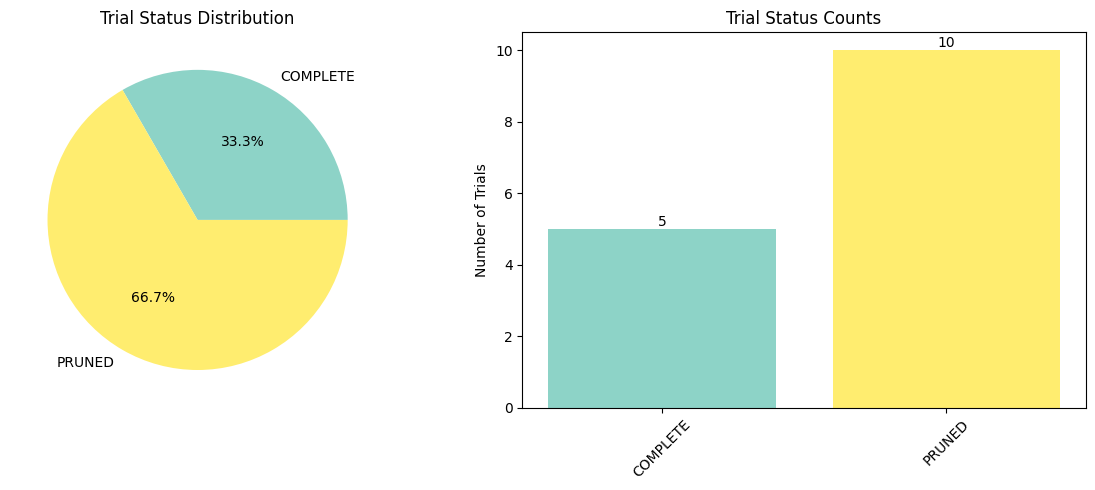


6. Top 10 Best Trials:
Rank Trial#  Score      bert_pos_weight batch_size   lr           max_epochs   weight_decay
-------------------------------------------------------------------------------------------
1    0       0.8401     29.6735      4            0.0000       4            0.0240      
2    1       0.8245     72.5612      4            0.0000       4            0.0119      
3    12      0.7844     58.8561      4            0.0000       4            0.0183      
4    2       0.7687     25.5923      4            0.0000       4            0.0290      
5    6       0.7178     41.5465      4            0.0001       3            0.0150      

7. Study Statistics Summary:
• Total trials: 15
• Successful trials: 5
• Failed trials: 0
• Success rate: 33.3%
• Best trial: #0
• Best objective value: 0.8401
• Score statistics:
  - Mean: 0.7061
  - Std:  0.1952
  - Min:  0.0427
  - Max:  0.8654
• Study direction: MAXIMIZE
• Sampler: TPESampler


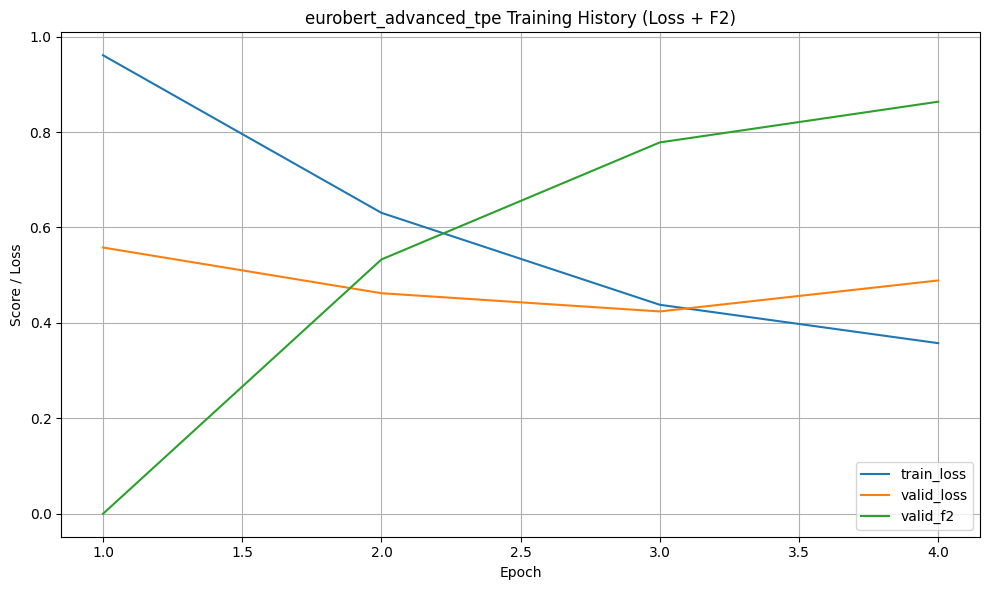


Optimizing threshold with nested cross-validation (coarse-to-fine)...


c:\Users\tdoro\Documents\GitHub\clean-repo\src\eurobert_skorch.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
c:\Users\tdoro\Documents\GitHub\clean-repo\src\eurobert_skorch.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Optimized threshold: 0.021
CV F2-score with optimized threshold: 0.930

Generating unbiased threshold visualization...


c:\Users\tdoro\Documents\GitHub\clean-repo\src\eurobert_skorch.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Final Threshold: 0.02
F2-score with default threshold (0.5): 0.805

Test Set Performance:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       146
           1       0.80      0.81      0.81        54

    accuracy                           0.90       200
   macro avg       0.87      0.87      0.87       200
weighted avg       0.90      0.90      0.90       200

Additional Metrics:
Accuracy   0.895
F2-score   0.812
AUC-ROC    0.934
AUC-PR     0.849



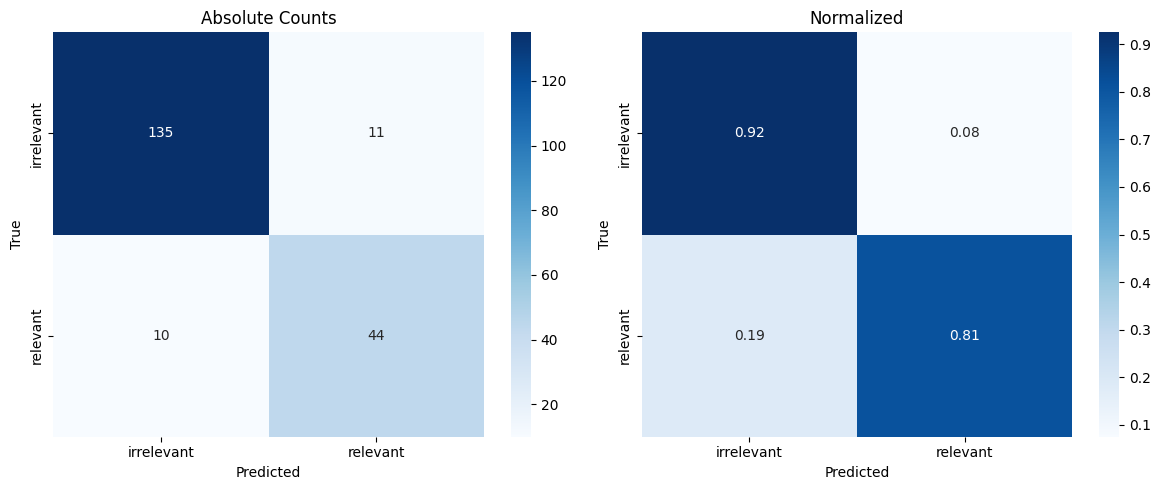

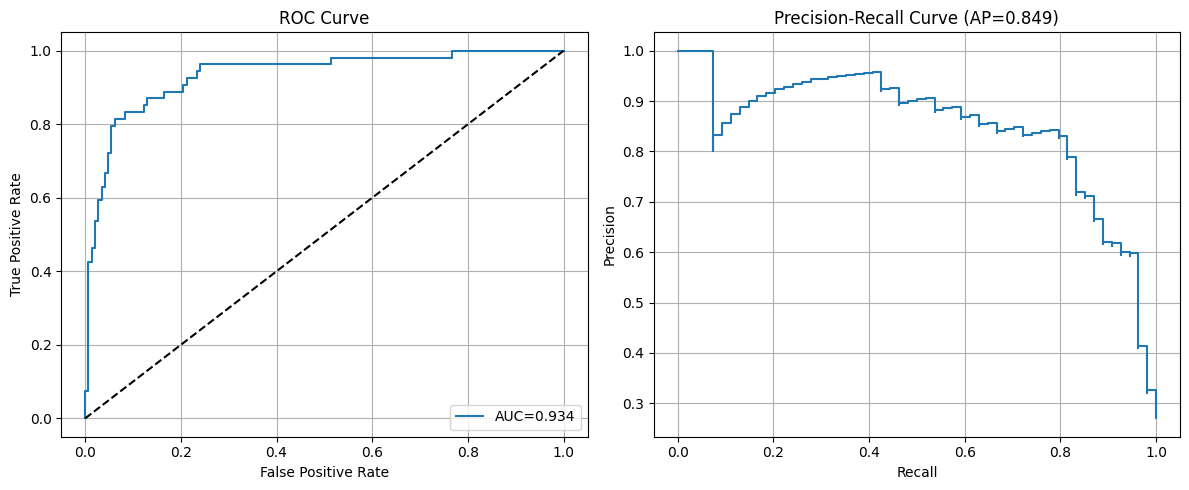

c:\Users\tdoro\Documents\GitHub\clean-repo\src\eurobert_skorch.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Model saved as model_eurobert_advanced_tpe.joblib


In [6]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_advancedcleaned["SegmentText"], df_advancedcleaned["Label"],
    test_size=0.2,
    stratify=df_advancedcleaned["Label"],
    random_state=42
)

# Note: PhraseDetector is not applied for EuroBERT, since subword tokenization 
# and self-attention already capture multiword expressions. 
# Including it here would waste trials in the limited budget (15).
 
pipeline_eurobert = Pipeline([
    ("clf", make_eurobert_skorch(
        model_name="EuroBERT/EuroBERT-210m",
        max_length=1000,
        max_epochs=5,
        lr=2e-5,
        batch_size=16,
        force_cuda=True
    ))
])

# CV Strategy (consistent across all sections)
# test with 3 to run faster 
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

# Optuna Parameter Space 
print("Starting Optuna hyperparameter optimization ...")

# Define parameter space for Optuna optimization
param_space = {
    "clf__lr": lambda t: t.suggest_float("clf__lr", 1e-5, 1e-4, log=True),
    "clf__batch_size": lambda t: t.suggest_categorical("clf__batch_size", [4, 8]),
    "clf__max_epochs": lambda t: t.suggest_int("clf__max_epochs", 2, 5),
    "clf__optimizer__weight_decay": lambda t: t.suggest_float("clf__optimizer__weight_decay", 0.01, 0.1),
    "clf__criterion__weight": lambda t: torch.tensor([1.0, t.suggest_float("bert_pos_weight", 25.0, 75.0, log=True)], dtype=torch.float32),
}

model_name = "eurobert_advanced_tpe"

# Execute Optuna optimization with TPE sampler
best_model, best_params, study = optimize_with_optuna_tpe(
    estimator=pipeline_eurobert,
    param_space=param_space,
    X=X_dev,
    y=y_dev,
    cv=cv,
    model_type="eurobert",
    n_trials=15,           
    n_startup_trials=2,
    n_warmup_steps=2,
    intervall_steps=1,
    direction="maximize",
    random_state=SEED,
    verbose=False,
    log_to_file=True,
    model_name=model_name
)
print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# plot loss curves
net = base_model.named_steps['clf']
plot_skorch_history(net=net, keys=['train_loss', 'valid_loss','valid_f2'])
plt.title(f'{model_name} Training History (Loss + F2)')
plt.show()


# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=15,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=1,
    random_state=SEED,
    retrain=False #eurobert big model
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")
'''
viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10),
    n_jobs=1  # Use single thread for learning curves to avoid overhead 
)
plt.suptitle(f'{model_name} with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()
'''
# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1]

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print(f"F2-score with default threshold (0.5): {quick_f2_score_default_threshold(y_test, y_test_proba):.3f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1]
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': model_name, 
    'preprocessing_type': 'advanced',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")



EuroBERT GridSearch advanced

In [ ]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_advancedcleaned["SegmentText"], df_advancedcleaned["Label"],
    test_size=0.2,
    stratify=df_advancedcleaned["Label"],
    random_state=42
)


pipeline_eurobert = Pipeline([
    ("clf", make_eurobert_skorch(
        model_name="EuroBERT/EuroBERT-210m",
        max_length=1000,
        max_epochs=5,
        lr=2e-5,
        batch_size=16,
        force_cuda=True
    ))
])

# CV Strategy (consistent across all sections)
# test with 3 to run faster 
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

# Optuna Parameter Space 
print("Starting Optuna hyperparameter optimization ...")

param_grid = {
    "clf__lr": [1e-5, 1.2e-5],
    "clf__optimizer__weight_decay": [0.015, 0.025],
    "mlp_pos_weight": [30.0, 45.0, 60.0],
    "clf__batch_size": [4],
    "clf__max_epochs": [4],
}

model_name = "eurobert_advanced_gridsearch"

#grid search
best_model, best_params, study = grid_search_with_optuna(
    estimator=pipeline_eurobert,
    param_grid=param_grid,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    random_state=42,
    model_name=model_name,
    n_jobs=1
)

print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# plot loss curves
net = base_model.named_steps['clf']
plot_skorch_history(net=net, keys=['train_loss', 'valid_loss','valid_f2'])
plt.title(f'{model_name} Training History (Loss + F2)')
plt.show()


# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=15,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=1,
    random_state=SEED,
    retrain=False #eurobert big model
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")
'''
viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10),
    n_jobs=1  # Use single thread for learning curves to avoid overhead 
)
plt.suptitle(f'{model_name} with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()
'''
# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1]

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print(f"F2-score with default threshold (0.5): {quick_f2_score_default_threshold(y_test, y_test_proba):.3f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1]
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': model_name, 
    'preprocessing_type': 'advanced',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")



c:\Users\tdoro\Documents\GitHub\clean-repo\src\eurobert_skorch.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self._scaler = GradScaler() if self.use_amp else None
c:\Users\tdoro\Documents\GitHub\clean-repo\src\eurobert_skorch.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self._scaler = GradScaler() if self.use_amp else None


Starting Optuna hyperparameter optimization ...


`torch_dtype` is deprecated! Use `dtype` instead!
Some weights of EuroBertForSequenceClassification were not initialized from the model checkpoint at EuroBERT/EuroBERT-210m and are newly initialized: ['classifier.bias', 'classifier.weight', 'dense.bias', 'dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\tdoro\Documents\GitHub\clean-repo\src\eurobert_skorch.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
